## 1.Text to Speech

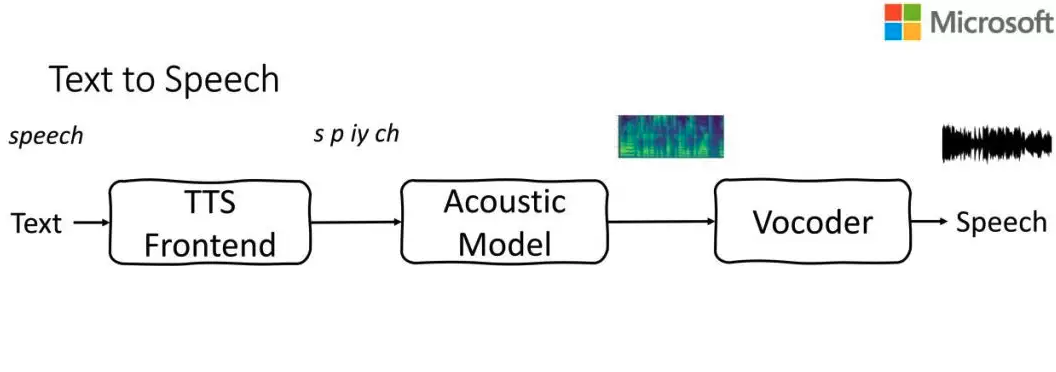

TTS系统的构成主要分为3个部分：TTS Frontend（TTS前端）、Acoustic Model（声学模型）、Vocoder（声码器）。

我们的TTS系统主要是基于近年来发展迅速的神经网络端到端的语音合成系统。这里没有涉及传统的参数法或者拼接法以及基于神经网络的参数法，因为学术界和工业界都在从传统的方法转到基于端到端的神经网络模型。最近学术界也有些更极端的做法，比如完全舍弃了TTS前端，直接把语音的文本作为输入，或者把声码器部分和声学模型部分集成在一起进行端到端的训练。这样的一些前沿的研究探索还没有在工业界得到广泛的应用，所以我们本次的分享，还是基于工业界和学术界广泛认可和接受的合成系统。

首先，**TTS前端的主要功能就是给定一个文本生产它的发音信息及语言学信息，声学模型基于上述的信息生成声学对应的特征，这里用的比较多的特征是梅尔频谱，然后声码器部分基于生成的声学特征作为条件信息来合成最后的语音波形图**。

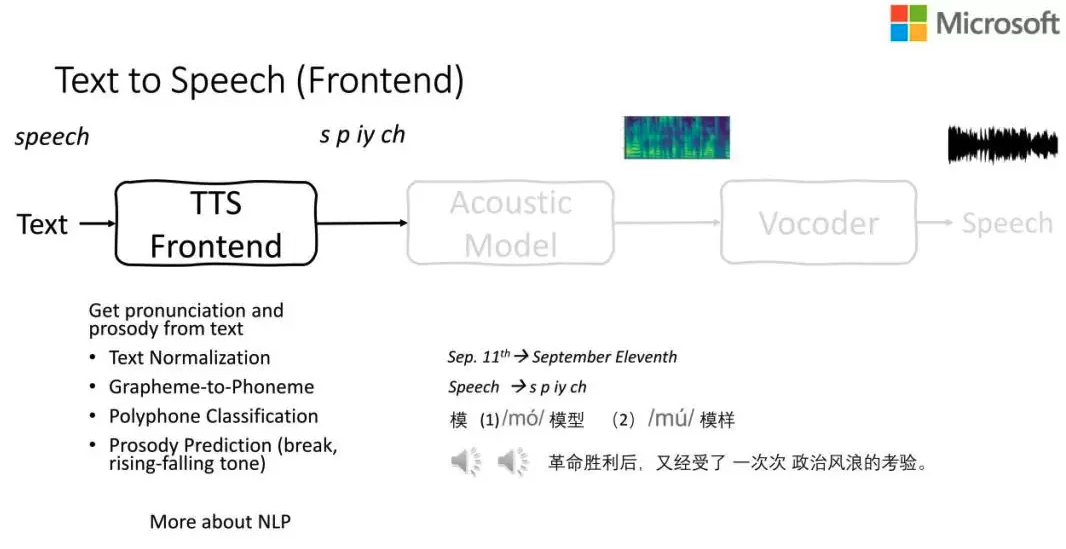

前端的主要功能是从文本信息产生发音和语言学的信息，其任务包括：

- Text Normalization（文本归一化）：在语音合成中常见的文字很多是简写或者缩写的，需要把这些文字标准化。如Sep.11th需要展成全写的September Eleventh，方便后面进行语言学分析。

- Grapheme-to-Phoneme（字形转音形）：利用发音词典和规则生成音素。音素一般利用ASCII编码，比如SAMPA和ARPAbet，这种编码在深度模型中也可以被支持。比如speech是这个文本的字形，需要先把它转化成音素s p iy ch，也就是发音信息，方便后面的声学模型更准确的知道这个文本发什么样的音。

- Polyphone Classification（多音字分类）：很多语言中都有多音字的现象，比如模型和模样，这里的模字就发不同的音。所以在输入一个句子的时候，前端就需要准确判断出这个字的发音，否则后端的声学模型可能会发音不准。

- Prosody Prediction（break，rising-falling tone）：还有些任务是对韵律进行预测，包括句子中词与词之间的停顿或者句子整体的升降调信息。如：革命胜利后，又经受了一次次政治风浪的考验，如果停顿信息不准确就会出现：革命胜利后，又经受了 一次  次 政治风浪的考验，在一次次的地方有一个停顿，这是不该有的，会导致语音合成的信息不自然，如果再严重点可能会影响语音信息的传达。

这就是整个前端所涉及到的任务，更多的是涉及NLP的知识。前端和后端基本独立。

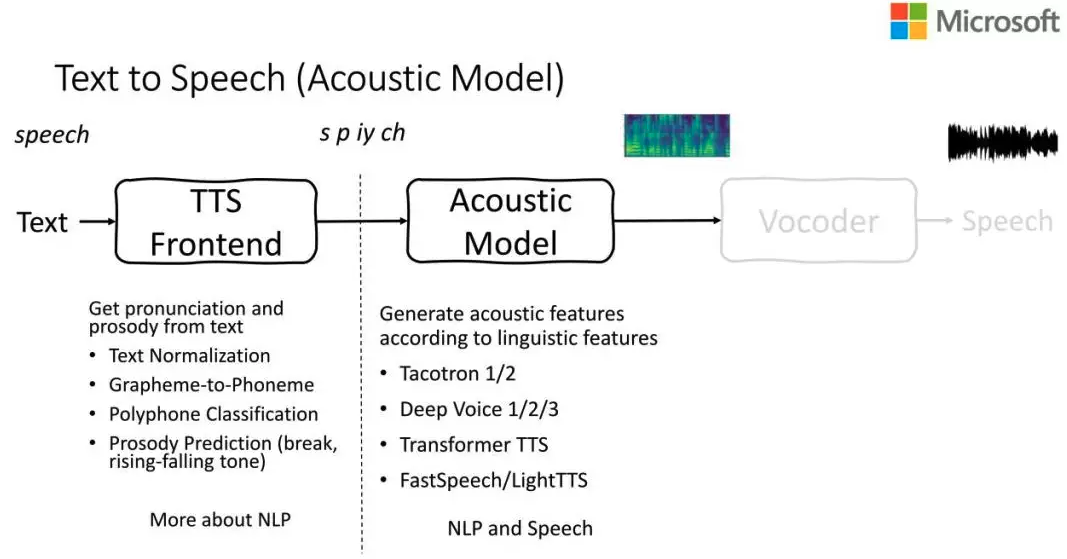

声学模型主要是基于前端产生的发音信息或者语言学信息来产生声学的特征，前端的信息其实是可以简化的，甚至不用前端的信息，可以直接用字符作为输入或者简单点用音素做为输入，或者更复杂的，我们可以设计出成百上千维的ID Feature来作为输入。输出的声学特征，目前TTS用的比较多的是梅尔频谱图。声学模型主要包括的模型有：

- Tacotron 1/2 

- Deep Voice 1/2/3

- Transformer TTS

- FastSpeech, LightTTS

在声学模型这部分，既涉及到NLP的知识，也涉及到Speech的知识。

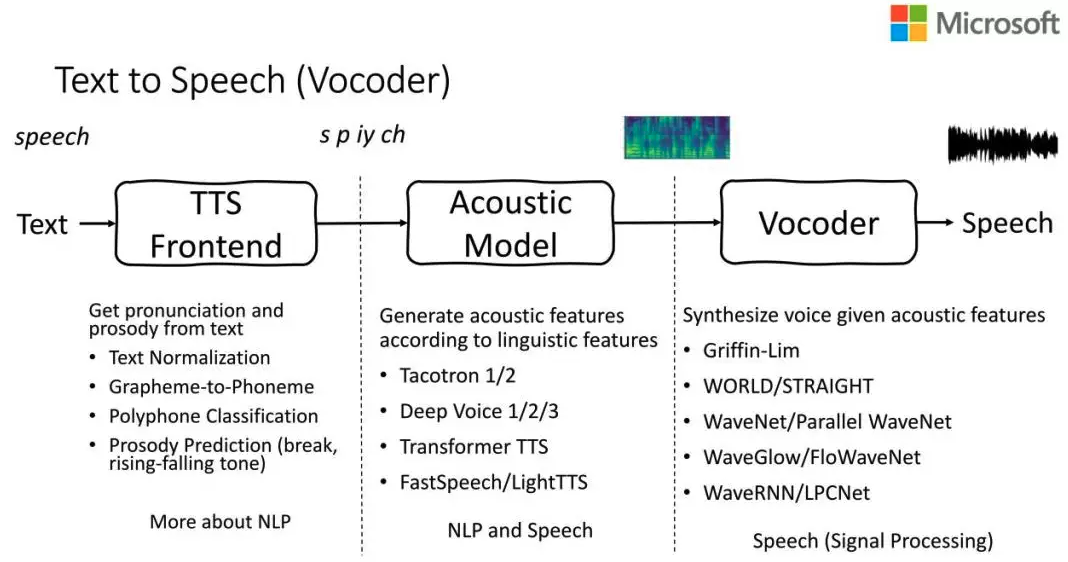

声码器主要作用是基于声学模型生成的声学特征来合成最后声音的波形图。常用的声码器有：

- Griffin-Lim

- WORLD/STRAIGHT

- WaveNet/Parallel WaveNet

- WaveGlow/FloWaveNet

- WaveRNN/LPCNet

Vocoder部分更多涉及的是语音的知识，如信号处理等相关的知识。

## 2.TTS中涉及的资源

- Data resource
    
    * High quality recordings (高质量的录音数据，其获取成本比一般的语音识别任务所需录音数据高)
    
    * Text and audio pairs (训练声学模型需要文本和语音配对数据)
    
    * TN rules, grapheme to phoneme data, polyphone, prosody labeled data (在做TTS前端模型时，需要很多相关的数据，如文本归一化所用到的规则或者模型、字形转音形的配对数据作为发音的词典或训练模型、以及多音字的数据或者语句停顿、韵律、升降调的标注信息。)
    
- Computation resource: CPU/GPU
    
    * Offline training
    
    * Online serving and inference
    
## 3.TTS低资源工作

具体工作包括：

- FastSpeech：这是一个快速的、轻量级的语音合成系统，能够并行的产生声学特征，所以主要是为了应对低计算资源问题。这个工作今年被NeurlPS 2019接收。

- LightTTS：在低配对资源情况下，构建TTS系统，来解决低数据资源的问题。这个工作今年被ICML 2019接收。

- LightBERT for TTS frontend：构建了TTS轻量级的前端模型，能够在线上做快速的inference，也是为了解决在线的低计算资源问题。

首先了解下FastSpeech面临的问题背景。

基于神经网络端到端的TTS已经比传统的拼接法或者参数法都显示出更强的特性。主流的模型包括：Emphasis、Tacotron、Deep Voice、Transformer等。这些模型比较类似的还是用的**传统的自回归模型**来生成声学特征。

这些模型面临的主要问题有：

- Inference 的速度很慢，如一个几秒的语音在梅尔频谱的帧数上大概几百帧，如果用自回归来生成梅尔频谱，整个生成速度会非常慢。

- 不鲁棒，传统的模型很多都在用encoder-attenion-decoder的结构，TTS中常遇到的就是重复字和漏字的问题，很大部分原因是由于attention机制导致的整个语音不鲁棒。

- 很难控制语音的速度，由于大部分模型都是自回归模型，很难控制语音合成的速度和韵律。

## 4.Model Architecture

**It consists of two components**

- 1.Network: Convert character sequences to **mel spectrogram**

- 2.Modified WaveNet(vocoder):Synthesize time-domain waveform from those **mel spectrogram**

**What's wrong with WaveNet?**

The input requires linguistic features,fundamental frequencies and phoneme durations all of this which requires significant domain knowledge to interpret and process.

**How to solve?**

Tacotron alleviate this problem with **sequence-to-sequence architecture** where the input character sequences were transformed into magnitude(幅度) spectrograms. This eliminated the need for complex linguistic and acoustic input features as we could now use raw data in the original Tacotron, the spectrogram was passed into a vocoder which used the **Griffin-Lim algorithm **for speech synthesis

**Why use mel spectrogram as its intermediate form?**

- 1.It facilitates faster training of the network part and wavenet modification parts separately. 

- 2.Emphasizes lower frequency signals,allowing better intelligibility when converting to speech.低频信号具有更多的音频信息。

## Spectrogram Prediction Network

- 1.**Encoder**:Convert character sequence to internal feature representation(内部特征表示).

- 2.**Decoder**:Convert feature representation to frames of mel spectrogram.

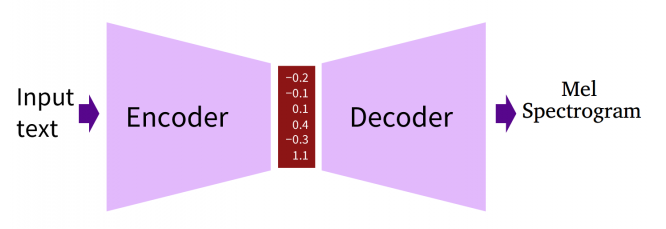

encoder输入一个序列或句子，然后将其压缩到一个固定长度的向量(向量也可以理解为一种形式的序列)中，decoder使用固定长度的向量，利用attention关注向量的不同部分，将其解压成一个序列。

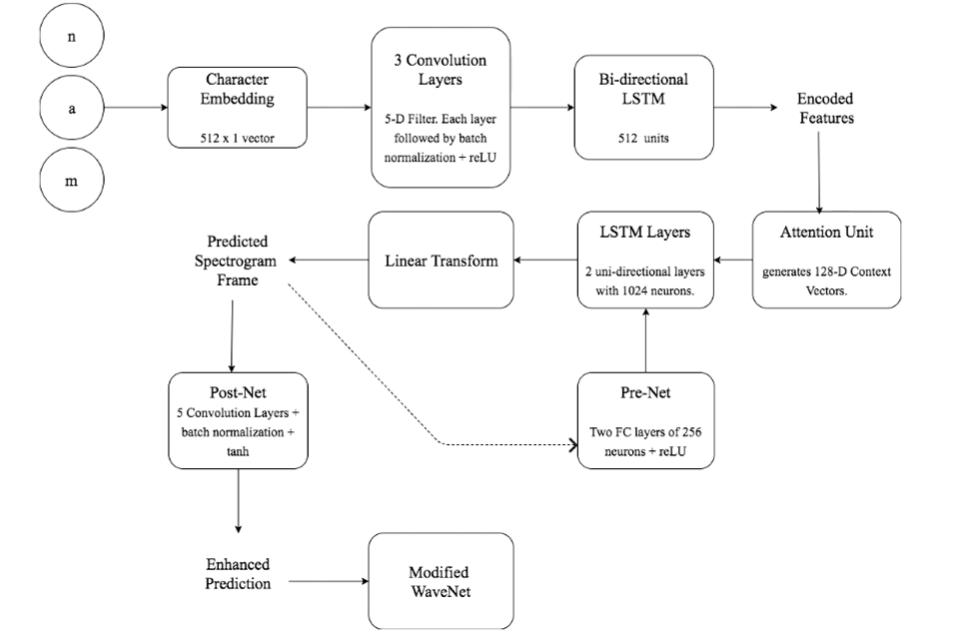

### 3.1. Tacotron

要介绍Tacotron2就需要先了解Tacotron。Tacotron是第一个端对端的TTS神经网络模型，输入raw text，Tacotron可以直接输出mel-spectrogram，再利用Griffin-Lim算法就可以生成波形了。模型的总体架构如下图所示：

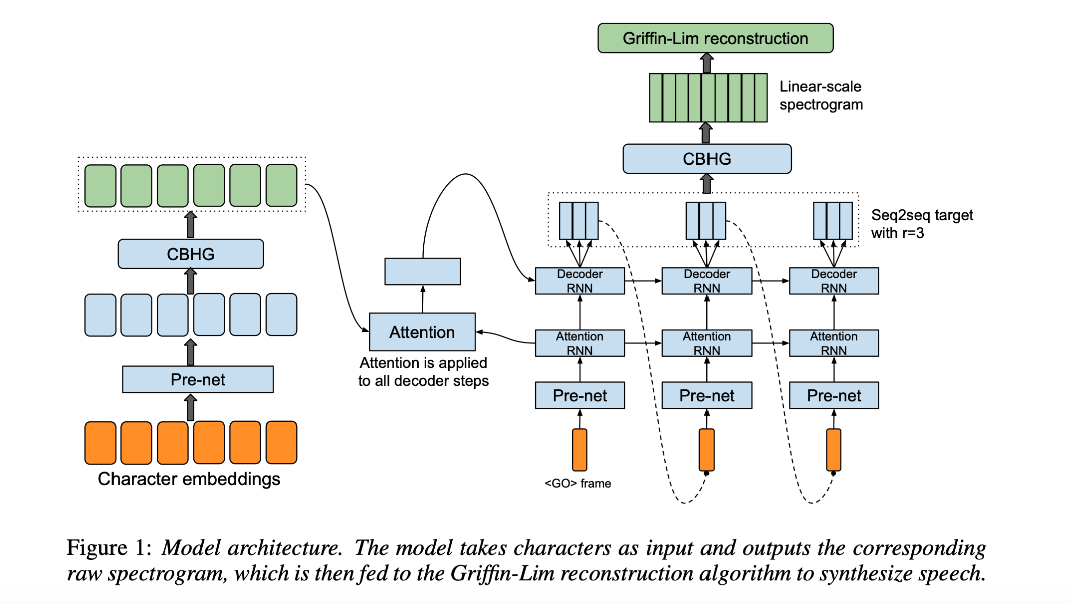

总体来说，模型和sequence-to-sequence模型非常相似，大体上由encoder和decoder组成，raw text经过pre-net, CBHG两个模块映射为hidden representation，之后decoder会生成mel-spectrogram frame。

代码参考的是 https://github.com/keithito/tacotron